In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
from tqdm.notebook import tqdm

from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

# hp-VPINNs: One-dimensional Poisson's equation

Let $u(x):\Omega \rightarrow \mathbb{R}$, donde $\Omega =[-1,1]$. We consider the problem 


\begin{align}
- \dfrac{d^2u(x)}{dx^2} = f(x) \\
u(0)=g, \,\,\,\,\, u(1) = h. 
\end{align}

Let the approximate solution $u(x) \approx u_{NN}(x)$. Then, the strong-form residual is:

\begin{align}
r(x) &= - \dfrac{d^2u(x)}{dx^2} - f(x)  \tag{3}\\
r_b(x) &= u_{NN}(x) - u(x), \,\,\,\, x = 0, \,\, x = 1 . \tag{4}
\end{align}

We divide the domain $\Omega$ into non-overlaping elements $\Omega_e = [x_{e-1}, x_{e}]$. We choose a set of localized non-overlaping test functions $v_k(x)$ with nonvanishing function to be the high-order polynomial $P_{k-1}(x)-P_{k}(x)$, in wich $P_(k)(x)$ is Legendre polynomial of order $k$. The variational residual becomes

$$\mathcal{R}_k = \sum_{e = 1}^{N_{el}} \mathcal{R}_{k}^{(e)} = \sum_{e = 1}^{N_{el}} \int_{x_{e-1}}^{x_{e}} \left( - \dfrac{d^2u_{NN}(x)}{dx^2} - f(x) \right) v_{k}^{(e)}(x). \tag{5}$$

The variational forms by integrating by parts the first term of $\mathcal{R}_{k}^{(e)}$

$$\mathcal{R}_{k}^{(e)} = \int_{x_{e-1}}^{x_{e}} \dfrac{du_{NN}(x)}{dx}\dfrac{dv_{k}^{(e)}(x)}{dx} dx  - \dfrac{du_{NN}(x)}{dx}v_{k}^{(e)}(x)\Bigg|_{x_{e-1}}^{x_{e}} - \int_{x_{e-1}}^{x_{e}} f(x)v_{k}^{(e)}(x)dx.\tag{6}$$



The first term of (6) vanish. The corresponding variational loss function take the form

$$\mathcal{L} = \sum_{e=1}^{N_{el}}\dfrac{1}{K^{(e)}}\sum_{k = 1}^{K^{(e)}} \left| \mathcal{R}_{k}^{(e)} \right|^2 + \dfrac{\tau_b}{2} \left(|u_{NN}(0) - g|^2 + |u_{NN}(1) - h|^2 \right), \tag{7}$$
where $K^{(e)}$ is the number of test function in element $e$.

# Comments on implementation

Let $x=g(u)$ be a linear function that takes the interval $[-1,1]$ into the interval $[a,b]$. In particular 
$$x= g(u) = \dfrac{b-a}{2}\,u + \dfrac{b+a}{2}.$$ 


On the other hand, let $v(x)$ be a function with compact support on the interval $[-1,1]$ (Legendre polynomial) and $v_k(x)$ a function defined on the interval $[a,b]$, where $v_k(x) := v(g^{-1}(x))$.



### 1. First Integral

\begin{align}
\int_{a}^{b} u_{NN}^{'}(x) v_{k}^{'}(x) dx &= \int_{a}^{b} u_{NN}^{'}(x) (v(g^{-1}(x)))' dx = \int_{a}^{b} u_{NN}^{'}(x) v'(g^{-1}(x)) \dfrac{dg^{-1}}{dx} dx = \int_{-1}^{1} u_{NN}^{'}(g(u)) v'(g^{-1}(g(u))) \dfrac{dg^{-1}}{dx} \dfrac{dg}{du}du \tag{8}\\
&= \int_{-1}^{1} u_{NN}^{'}(g(u)) v'(u) du \approx \sum_{i = 1}^{N_{1uad}} w_i \, u_{NN}^{'}(g(u_i))v^{'}(u_i). \tag{9}
\end{align}
Note that $\dfrac{dg^{-1}}{dx} \dfrac{dg}{du} =  \dfrac{du}{dx} \dfrac{dx}{du} = 1 $. 

### 2. Second Integral

$$\int_{a}^{b} f(x) v_{k}(x) dx = \int_{a}^{b} f(x) v(g^{-1}(x)) dx = \int_{-1}^{1} f(g(u)) v(g^{-1}(g(u)))\dfrac{dg}{du}du = \dfrac{b-a}{2}\int_{-1}^{1} f(g(u)) v(u)du \approx \dfrac{b-a}{2}\sum_{i=1}^{N_{quad}} w_i f(g(u_i)) v(u_i), \tag{10}$$
where $u_i$, and $w_i$ are the points and weights of a quadrature.

# Code

In [2]:
# Legendre Polynomial   
def Test_fcn(n,x):
    test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
    return test

# Real Solution 
def u_ext(x):
    return x/2 * (1-x)
    
# Right-hand side function
def f_ext(x):
    return np.ones_like(x)

In [3]:
# Parameters
N_element = 5
N_testfcn = 50 
N_quad = 80 
loss_weight = 1 

# Generate quadrature points
x_quad, w_quad = GaussJacobiWeights(N_quad, 0, 0)
testfcn = np.asarray([Test_fcn(n,x_quad) for n in range(1,N_testfcn+1)])

In [4]:
# # Legendre basis
# for i in range(N_testfcn):
#     plt.plot(x_quad,testfcn[i,:])

In [5]:
# Elements
[x_l, x_r] = [0,1]
delta_x = (x_r - x_l)/N_element
grid = np.asarray([x_l + i*delta_x for i in range(N_element+1)])
N_testfcn_total = np.array((len(grid)-1)*[N_testfcn])          # total number of test functions by interval

In [6]:
# Integral f * v_k
F_ext_total = []
for e in range(N_element):
    x_quad_element = (grid[e+1] - grid[e])/2 * (x_quad) + (grid[e+1] + grid[e])/2
    jacobian = (grid[e+1] - grid[e])/2
    N_testfcn_temp = N_testfcn_total[e]
    testfcn_element = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn_temp+1)])

    f_quad_element = f_ext(x_quad_element)
    F_ext_element =  jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
    F_ext_element = F_ext_element[:,None]
    F_ext_total.append(F_ext_element)

In [7]:
# Boundary conditions
X_u_train = np.asarray([0.0,1.0])[:,None]
u_train   = u_ext(X_u_train)

In [8]:
class PINNs(nn.Module):
    def __init__(self, grid, F_ext_total, X_u_train, u_train, X_quad, W_quad, input_size = 1, hidden_size = 20,  num_layers = 4, output_size = 1):
        super(PINNs, self).__init__()

        # Mean square error
        self.loss_function = nn.MSELoss(reduction ='mean')

        # Feed Forward Neural Network
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            self.hidden_layers.add_module('linear'+str(l), nn.Linear(input_size, hidden_size))
            self.hidden_layers.add_module('tanh'+str(l), nn.Tanh()) 
            input_size = hidden_size
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        self.losses = {'Loss': []}   

        self.F_ext_total = F_ext_total

        self.N_elements = len(self.F_ext_total)
        self.N_testfcn = self.F_ext_total[0].shape[0]
        self.grid = grid

        # Cuadrature np.array
        self.xquad = X_quad
        self.wquad = W_quad
        self.wquad_tensor = torch.tensor(self.wquad, dtype=torch.float32, requires_grad=True)

        self.X_u_train = torch.tensor(X_u_train).float()
        self.u_train = torch.tensor(u_train).float()

        self.weight = 1.0


    # Forward pass
    def forward(self, x):
        return self.hidden_layers(x)

    # Derivative of the neural network
    def net_du(self,x):
        u = self.forward(x)
        d1u = torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u), create_graph=True)[0]
        d2u = torch.autograd.grad(d1u, x, grad_outputs = torch.ones_like(d1u), create_graph=True)[0]
        return d1u, d2u
    
    # Test Funcition Legendre Polynomials
    def Test_fcn(self, N_test, x):
        test_total = []
        for n in range(1,N_test+1):
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)
    
    # Derivative of Test Function Legendre Polynomials
    def dTest_fcn(self, N_test,x):
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)
    

    def loss_BC(self):
        u_pred = self.forward(self.X_u_train)
        return self.loss_function(u_pred, self.u_train)
    
    def loss_PDE_var(self):
        loss_NN_total = 0.0
        for e in range(self.N_elements):
            F_ext_element = self.F_ext_total[e]       
            Ntest_element = F_ext_element.shape[0]   # 50
            F_ext_element = torch.tensor(F_ext_element, dtype=torch.float32, requires_grad=True)

            # u_NN quad by element
            x_quad_elemet = torch.tensor((self.grid[e+1] - self.grid[e])/2 * (self.xquad) + (self.grid[e+1] + self.grid[e])/2, \
                                         dtype=torch.float32, requires_grad=True).view(-1,1)
            d1u_NN_quad_element, _ = self.net_du(x_quad_elemet) 
            d1u_NN_quad_element = d1u_NN_quad_element.squeeze()
            
            # Test function by element
            d1test_quad_element, _ = self.dTest_fcn(Ntest_element, self.xquad)
            d1test_quad_element = [torch.tensor(t, dtype=torch.float32, requires_grad=True) for t in d1test_quad_element]
            
            var_NN_element = torch.stack([sum(self.wquad_tensor * d1u_NN_quad_element * d1test_quad_element[i]) \
                                                  for i in range(Ntest_element)]).view(-1,1)

            Res_NN_element = var_NN_element - F_ext_element
            loss_NN_element = self.loss_function(Res_NN_element, torch.zeros_like(Res_NN_element))
            loss_NN_total += loss_NN_element
        return loss_NN_total


    def loss(self):
        loss_boundary = self.loss_BC()
        loss_PDE = self.loss_PDE_var()
        loss_total = self.weight * loss_boundary + loss_PDE
        return loss_total
    
    def train(self, epochs = 1000, lr = 0.01):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = self.loss()
            loss.backward()
            optimizer.step()
            self.losses['Loss'].append(loss.item())

            if epoch % 100 == 0:
                print('Epoch {}: Loss {}'.format(epoch, loss.item()))

In [9]:
model_1 = PINNs(grid, F_ext_total, X_u_train, u_train, x_quad, w_quad, input_size = 1, hidden_size = 20,  num_layers = 4, output_size = 1)

In [10]:
model_1.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 0.020754128694534302
Epoch 100: Loss 0.00014777033356949687
Epoch 200: Loss 4.031444859720068e-06
Epoch 300: Loss 3.657770093923318e-06
Epoch 400: Loss 3.3006192552420544e-06
Epoch 500: Loss 2.9526067919505294e-06
Epoch 600: Loss 2.139046773663722e-05
Epoch 700: Loss 5.234899617789779e-06
Epoch 800: Loss 4.182260909146862e-06
Epoch 900: Loss 3.401274398129317e-06


# Resultados

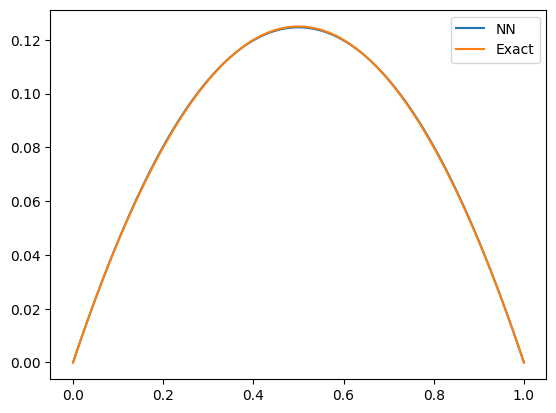

In [11]:
x_test = np.linspace(0,1,100)[:,None]
x_test_tensor = torch.tensor(x_test).float()
u_pred = model_1.forward(x_test_tensor).detach().numpy()
plt.plot(x_test, u_pred, label='NN')
plt.plot(x_test, u_ext(x_test), label='Exact')
plt.legend()
plt.show()

# Plotting

In [12]:
x_quad_plot = x_quad
y_quad_plot = np.empty(len(x_quad_plot))
y_quad_plot.fill(1)

x_train_plot = X_u_train
y_train_plot = np.empty(len(x_train_plot))
y_train_plot.fill(1) 

In [13]:
N_F = 500
Nf = N_F
X_f_train = lhs(1,Nf)
f_train   = f_ext(X_f_train)

x_f_plot = X_f_train
y_f_plot = np.empty(len(x_f_plot))
y_f_plot.fill(1)

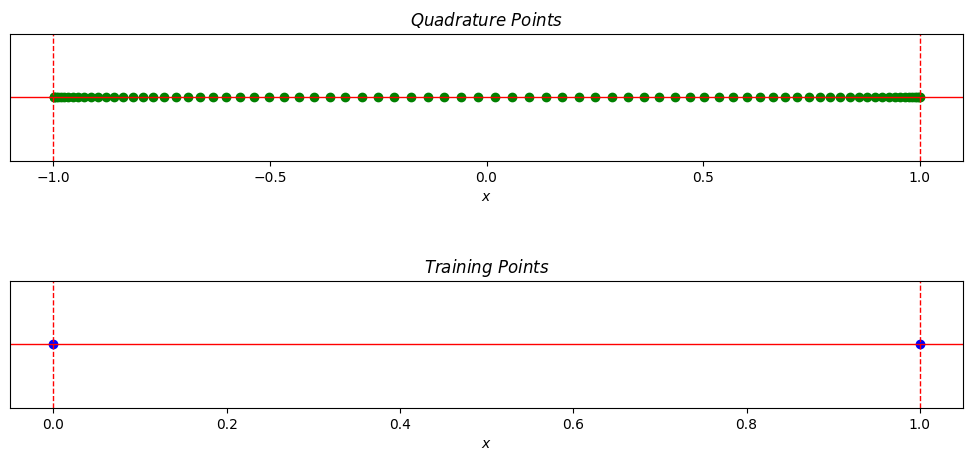

In [14]:
fig = plt.figure(0)
gridspec.GridSpec(3,1)

plt.subplot2grid((3,1), (0,0))
plt.tight_layout()
plt.locator_params(axis='x', nbins=6)
plt.yticks([])
plt.title('$Quadrature \,\, Points$')
plt.xlabel('$x$')
plt.axhline(1, linewidth=1, linestyle='-', color='red')
plt.axvline(-1, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
plt.scatter(x_quad_plot,y_quad_plot, color='green')

plt.subplot2grid((3,1), (1,0))
plt.tight_layout()
plt.locator_params(axis='x', nbins=6)
plt.yticks([])
plt.title('$Training \,\, Points$')
plt.xlabel('$x$')
plt.axhline(1, linewidth=1, linestyle='-', color='red')
plt.axvline(0, linewidth=1, linestyle='--', color='red')
plt.axvline(1, linewidth=1, linestyle='--', color='red')
plt.scatter(x_train_plot,y_train_plot, color='blue')

fig.tight_layout()
fig.set_size_inches(w=10,h=7)
#plt.savefig('Results/Train-Quad-pnts.pdf')   

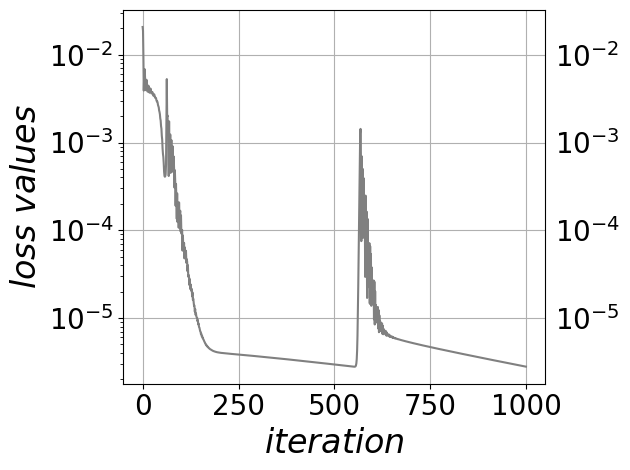

In [15]:
font = 24
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(model_1.losses['Loss'], 'gray')
plt.tick_params( labelsize = 20)
plt.tight_layout()
plt.show()

In [16]:
# Test point
delta_test = 0.001
xtest      = np.arange(0 , 1 + delta_test , delta_test)
data_temp  = np.asarray([ [xtest[i],u_ext(xtest[i])] for i in range(len(xtest))])
X_test = data_temp.flatten()[0::2]
u_test = data_temp.flatten()[1::2]
X_test = X_test[:,None]
u_test = u_test[:,None]
f_test = f_ext(X_test)
u_pred = model_1(torch.tensor(X_test, dtype = torch.float32)).detach().numpy() 

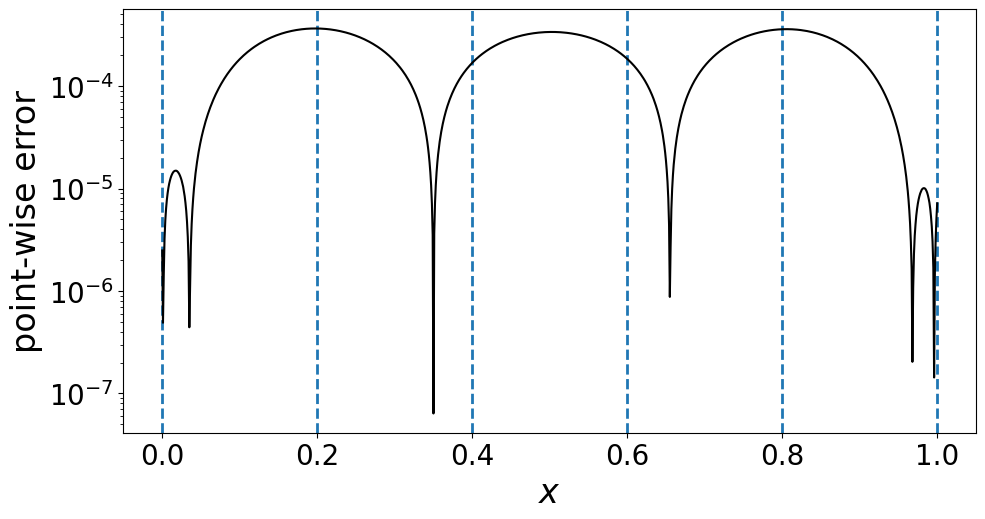

In [17]:
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('point-wise error', fontsize = font)
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(X_test, abs(u_test - u_pred), 'k')
plt.yscale('log')
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)

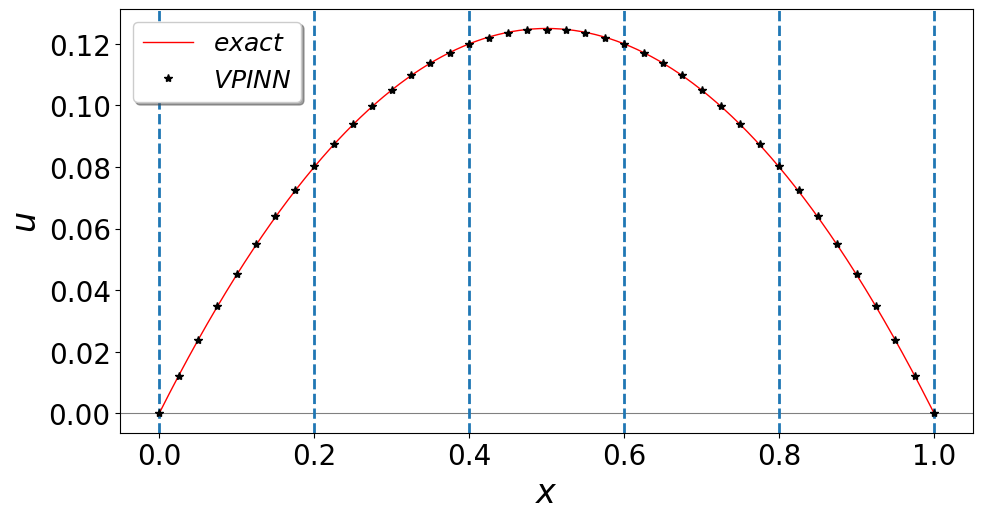

In [18]:
font = 24
pnt_skip = 25
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('$u$', fontsize = font)
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(X_test, u_test, linewidth=1, color='r', label=''.join(['$exact$']))
plt.plot(X_test[0::pnt_skip], u_pred[0::pnt_skip], 'k*', label='$VPINN$')
plt.tick_params( labelsize = 20)
legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
fig.set_size_inches(w=11,h=5.5)
